# Data exploration

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [2]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [3]:
data = pd.read_csv("datasets\combined_csv.csv",
                   dtype="object",
                   low_memory=False)
data.head(1)

,Id,AcceptedAnswerId,CreationDate,Score,ViewCount,Body,OwnerUserId,Title,Tags,AnswerCount,CommentCount
0,415160,NaN,2009-01-06 02:00:17,7,6374,<p>What is the best method for creating an <a ...,51886.0,Best method of Instantiating an XMLHttpRequest...,<javascript><ajax><cross-browser><xmlhttprequest>,9,1


In [4]:
data.shape

(2568165, 11)

## 1) Dealing with missing values and duplicated data

In [5]:
print((data.isnull().mean()\
       *100).round(2))

Id                   0.00
AcceptedAnswerId    43.42
CreationDate         0.00
Score                0.00
ViewCount            0.00
Body                 0.00
OwnerUserId          2.20
Title                0.00
Tags                 0.00
AnswerCount          0.00
CommentCount         0.00
dtype: float64


In [6]:
data.drop_duplicates(subset="Id", 
                     inplace=True)

In [7]:
data["CreationDate"] = pd.to_datetime(data["CreationDate"],
                                     format="%Y-%m-%d", 
                                     errors="ignore")
data["Score"] = data["Score"].astype("int32")
data["ViewCount"] = data["ViewCount"].astype("int32")
data["AnswerCount"] = data["AnswerCount"].astype("int32")
data["CommentCount"] = data["CommentCount"].astype("int32")

## 2) Determine characterics of a good question

First, we consider that posts without "AcceptedAnswerId" are bad posts. We delete these posts of our sample. 

In [8]:
data.dropna(subset=["AcceptedAnswerId"],
            inplace=True)
data.shape

(1438314, 11)

In [9]:
data.describe()

,Score,ViewCount,AnswerCount,CommentCount
count,1.438314e+06,1.438314e+06,1.438314e+06,1.438314e+06
mean,3.656626e+00,3.860701e+03,1.907445e+00,3.200809e+00
std,5.173774e+01,3.892935e+04,1.844153e+00,2.682042e+00
min,-2.500000e+01,5.000000e+00,1.000000e+00,1.000000e+00
25%,0.000000e+00,5.800000e+01,1.000000e+00,1.000000e+00
50%,0.000000e+00,1.680000e+02,1.000000e+00,2.000000e+00
75%,2.000000e+00,9.220000e+02,2.000000e+00,4.000000e+00
max,2.577800e+04,9.830871e+06,1.290000e+02,6.800000e+01


As we can see, some posts have only one answer or one comment. We make choice to keep only posts with two comments or more. We made the same with the "AnswerCount". 

In [10]:
data = data.loc[data["CommentCount"] >= 2]
data = data.loc[data["AnswerCount"] >= 2]
data = data.loc[data["Score"] >= 2]
data.shape

(164598, 11)

In [11]:
data.describe()

,Score,ViewCount,AnswerCount,CommentCount
count,164598.000000,1.645980e+05,164598.000000,164598.000000
mean,20.880059,1.998435e+04,3.948456,4.139115
std,142.902179,1.014772e+05,3.664750,2.870641
min,2.000000,1.600000e+01,2.000000,2.000000
25%,2.000000,4.430000e+02,2.000000,2.000000
50%,4.000000,2.317000e+03,3.000000,3.000000
75%,9.000000,9.310750e+03,4.000000,5.000000
max,25778.000000,9.830871e+06,129.000000,62.000000


## 3) Univariate analysis

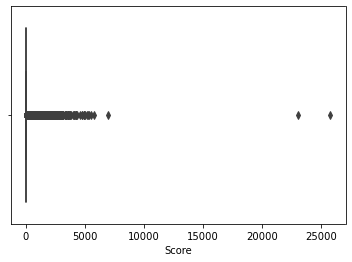

In [12]:
sns.boxplot(x="Score", 
            data=data)
plt.show()

In [13]:
data.loc[data["Score"] == data["Score"].max()]

,Id,AcceptedAnswerId,CreationDate,Score,ViewCount,Body,OwnerUserId,Title,Tags,AnswerCount,CommentCount
152971,11227809,11227902.0,2012-06-27 13:51:36,25778,1633806,<p>Here is a piece of C++ code that shows some...,87234.0,Why is processing a sorted array faster than p...,<java><c++><performance><cpu-architecture><bra...,27,7


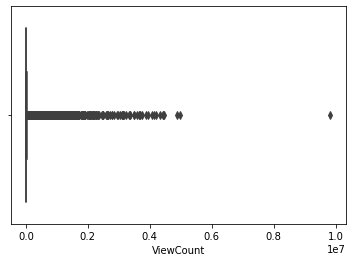

In [14]:
sns.boxplot(x="ViewCount", 
            data=data)
plt.show()

In [15]:
data.loc[data["ViewCount"] == data["ViewCount"].max()]

,Id,AcceptedAnswerId,CreationDate,Score,ViewCount,Body,OwnerUserId,Title,Tags,AnswerCount,CommentCount
45153,927358,927386.0,2009-05-29 18:09:14,23062,9830871,<p>I accidentally <strong>committed the wrong ...,89904.0,How do I undo the most recent local commits in...,<git><version-control><git-commit><undo>,96,11


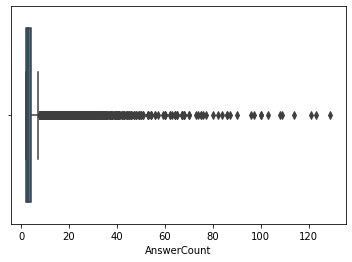

In [16]:
sns.boxplot(x="AnswerCount", 
            data=data)
plt.show()

In [17]:
data.loc[data["AnswerCount"] == data["AnswerCount"].max()]

,Id,AcceptedAnswerId,CreationDate,Score,ViewCount,Body,OwnerUserId,Title,Tags,AnswerCount,CommentCount
34947,450835,450899.0,2009-01-16 15:49:20,496,89353,"<blockquote>\n<p>I've accepted an answer, but ...",2486915.0,Stopping scripters from slamming your website,<scripting><e-commerce><bots><detection>,129,8


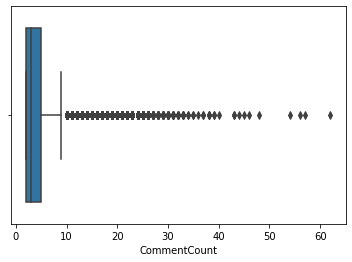

In [18]:
sns.boxplot(x="CommentCount", 
            data=data)
plt.show()

In [19]:
data.loc[data["CommentCount"] == data["CommentCount"].max()]

,Id,AcceptedAnswerId,CreationDate,Score,ViewCount,Body,OwnerUserId,Title,Tags,AnswerCount,CommentCount
866961,32758064,33007060.0,2015-09-24 09:37:07,7,1679,<p>I want to get the co-ordinates of the <code...,1566194.0,Draw Bitmap in Custom ImageView and get the Co...,<android><canvas><coordinates><draw><android-c...,3,62


## 4) Bivariate analysis

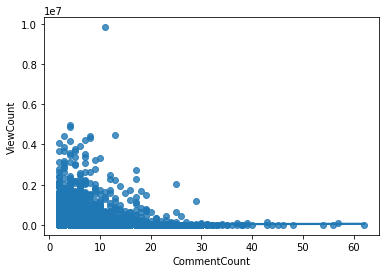

In [20]:
sns.regplot(x="CommentCount", 
            y="ViewCount", 
            data=data)
plt.show()

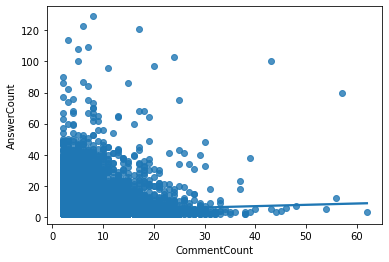

In [21]:
sns.regplot(x="CommentCount", 
            y="AnswerCount", 
            data=data)
plt.show()

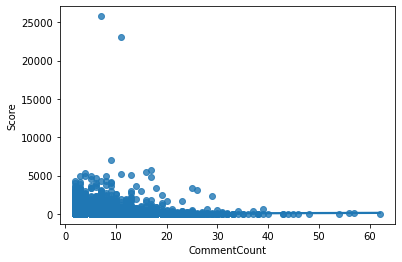

In [22]:
sns.regplot(x="CommentCount", 
            y="Score", 
            data=data)
plt.show()

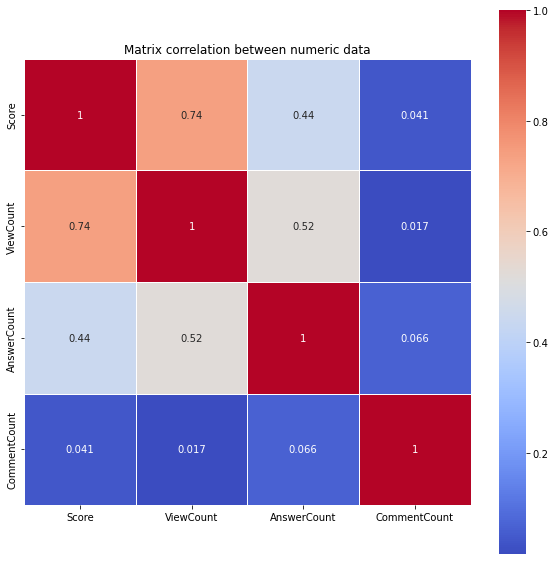

In [23]:
corr = data.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, 
            cmap="coolwarm", 
            annot=True,
            square=True,
            fmt=".2g",
            linewidths=.5)
plt.title("Matrix correlation between numeric data")
plt.show()

## 5) Textual data processing

In [24]:
stops = set(stopwords.words("english"))

In [25]:
print(stops)

{'most', 'there', 'is', 'can', "should've", 'was', 'why', 'do', 'here', 'mustn', 'did', 'd', 'him', "you're", 'it', 'very', 'wouldn', 'has', 'to', 'ourselves', "won't", 'once', 'a', "wouldn't", 'other', 'hers', 'm', 'having', 'nor', 'his', 'between', 's', 't', 'couldn', 'yourself', 'how', 'you', 'just', 'for', 'now', 'in', 'your', 'me', 'under', "doesn't", 'same', "isn't", 'haven', 'again', 'of', "you'll", "weren't", 'about', 'theirs', "you'd", 'but', "don't", "it's", 'wasn', 'myself', 'will', "hasn't", 'll', 'on', "haven't", 'himself', 'what', 'ours', 'my', 'yourselves', 'are', 'he', "shouldn't", 'and', 'mightn', 'herself', 'over', 'few', 'be', 'an', 'does', 'during', 'off', 'doing', 'above', "shan't", 'hadn', 'themselves', 'shouldn', 'we', 'each', 'own', 'both', 'at', 'any', 'by', 'the', 'am', "mustn't", 'our', 'its', 'their', 'before', 'don', 'being', "couldn't", 'didn', 'into', 'have', 'while', 'below', 'needn', 're', 'these', 'her', 'hasn', 'aren', 'had', 'itself', 'all', "mightn'

### a) Title cleansing

In [26]:
data["Title"] = data["Title"].str.lower()

In [27]:
data["Title"] = [w for w in data["Title"] if not w in stops]

### b) Tags cleansing

In [28]:
data["Tags"] = data["Tags"].str.replace("<", " ")
data["Tags"] = data["Tags"].str.replace(">", " ")
data.head(3)

,Id,AcceptedAnswerId,CreationDate,Score,ViewCount,Body,OwnerUserId,Title,Tags,AnswerCount,CommentCount
6,415192,415338.0,2009-01-06 02:17:54,139,195134,"<p>I've been using python for years, but I hav...",18866.0,best way to create a simple python web service,python web-services,9,2
10,415344,415370.0,2009-01-06 03:20:58,2,323,<p>I'm about to implement a logging class in C...,11125.0,what logging implementation do you prefer?,debugging language-agnostic logging,4,2
16,414981,414989.0,2009-01-06 00:00:53,35,49613,<p>I have this struct:</p>\n\n<pre><code>struc...,51816.0,directly modifying list<t> elements,c# .net,6,3


### c) Body cleansing

In [29]:
body_bs4 = [BeautifulSoup(i) for i in data["Body"]]
body_bs4 = [i.get_text() for i in body_bs4]
data["Body"] = [w for w in body_bs4 if not w in stops]
data["Body"] = data["Body"].str.lower()

In [30]:
data_posts = pd.DataFrame()
data_posts["Id"] = data["Id"]
data_posts["Title"] = data["Title"]
data_posts["Body"] = data["Body"]
data_posts["Tags"] = data["Tags"]

In [31]:
stemmer = SnowballStemmer("english")

In [32]:
title_str = [str(i) for i in data_posts["Title"]]
data_posts["Title"] = [stemmer.stem(i) for i in title_str]

In [33]:
body_str = [str(i) for i in data_posts["Body"]]
data_posts["Body"] = [stemmer.stem(i) for i in body_str]

In [34]:
data_posts.head(3)

,Id,Title,Body,Tags
6,415192,best way to create a simple python web servic,"i've been using python for years, but i have l...",python web-services
10,415344,what logging implementation do you prefer?,i'm about to implement a logging class in c++ ...,debugging language-agnostic logging
16,414981,directly modifying list<t> el,i have this struct:\nstruct map\n{\n public...,c# .net


## 6) Topics modeling

### a) Title

In [35]:
n_components = 10
n_top_words = 20

In [36]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tf_vectorizer = CountVectorizer(stop_words='english')

In [37]:
title_tfidf = tfidf_vectorizer.fit_transform(data_posts["Title"])
title_tf = tf_vectorizer.fit_transform(data_posts["Title"])

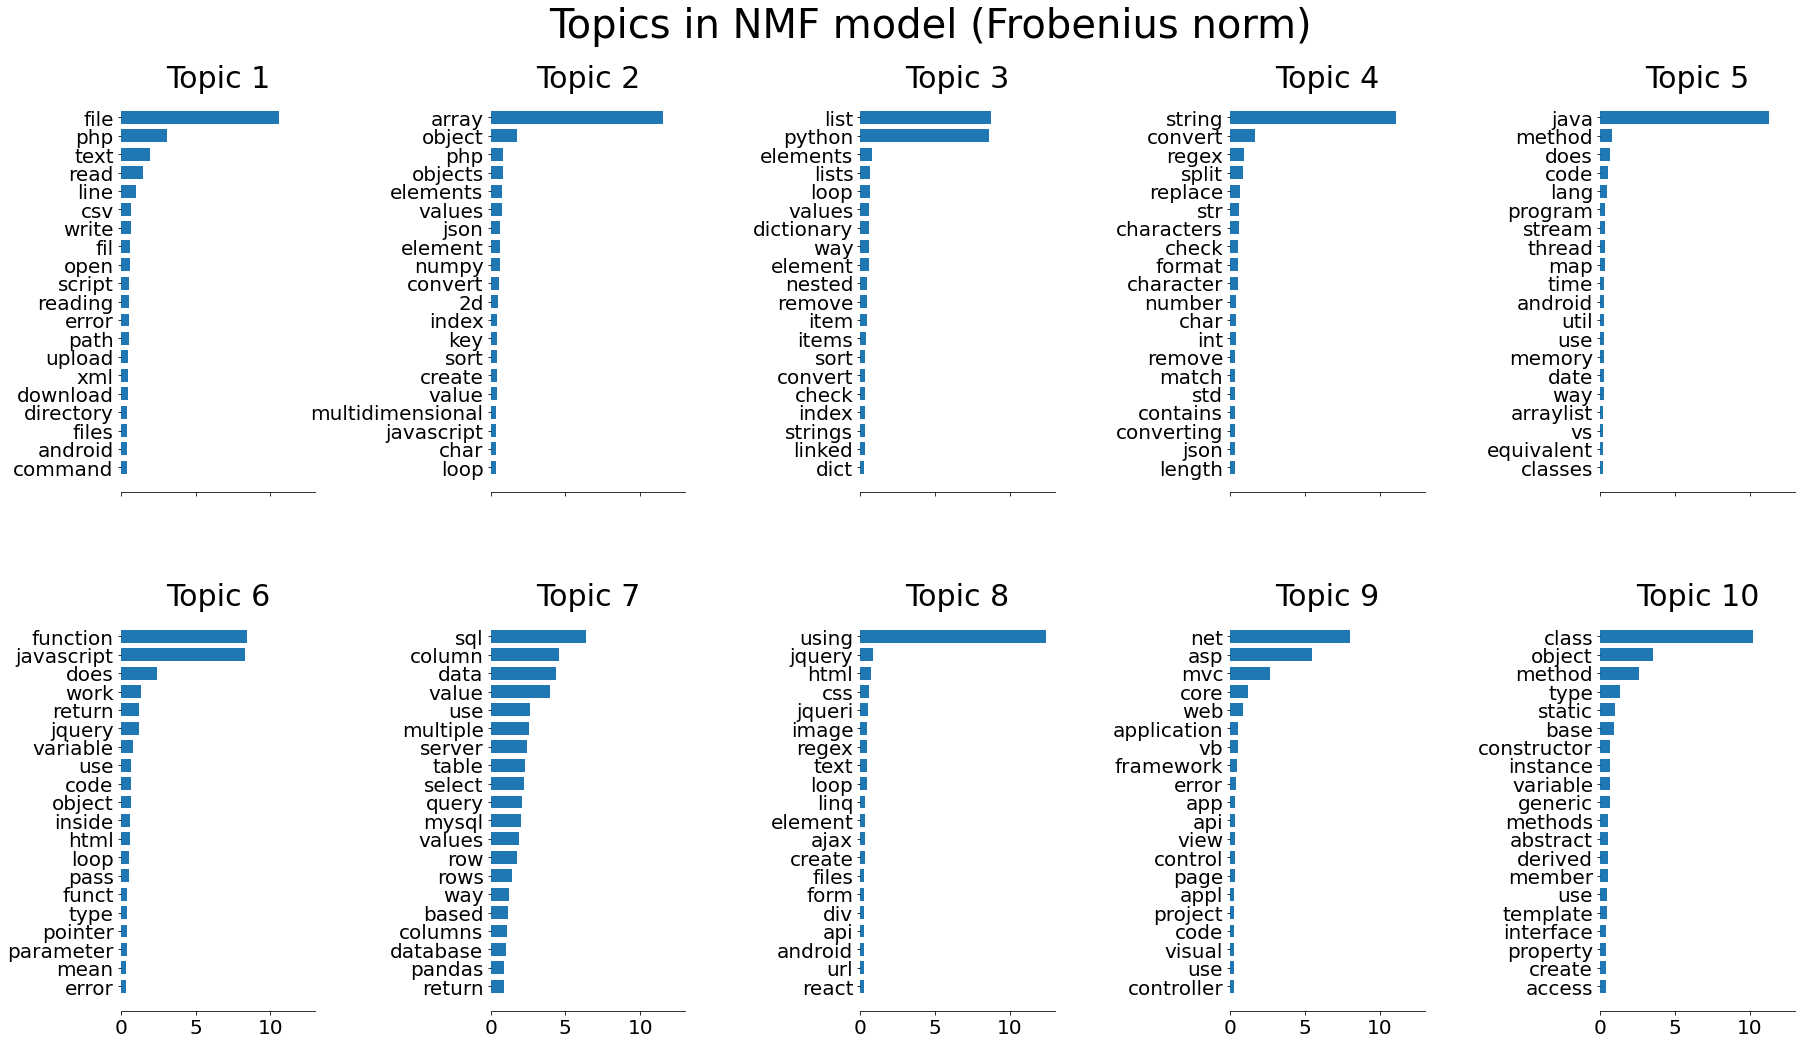

In [38]:
nmf = NMF(n_components=n_components, random_state=42,
          alpha=.1, l1_ratio=.5).fit(title_tfidf)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_top_words(nmf, tfidf_feature_names, n_top_words,
               'Topics in NMF model (Frobenius norm)')

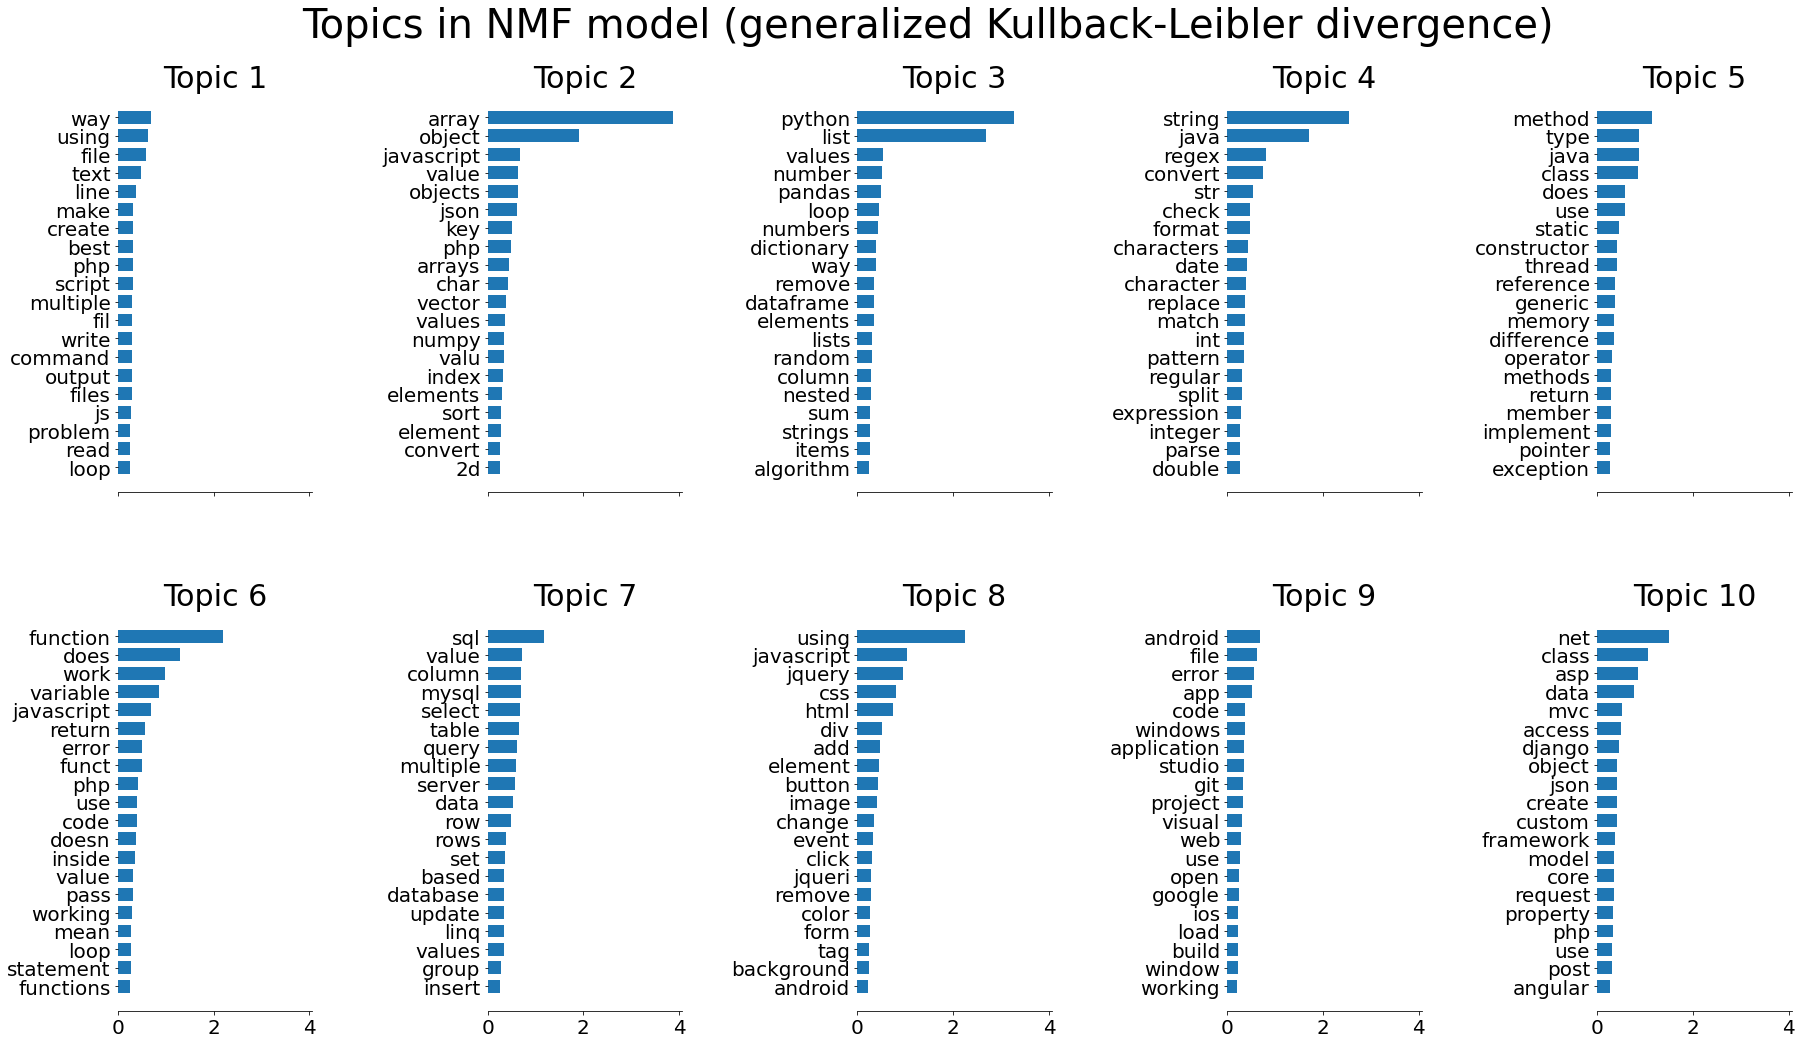

In [39]:
nmf = NMF(n_components=n_components, random_state=42,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5).fit(title_tfidf)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_top_words(nmf, tfidf_feature_names, n_top_words,
               'Topics in NMF model (generalized Kullback-Leibler divergence)')

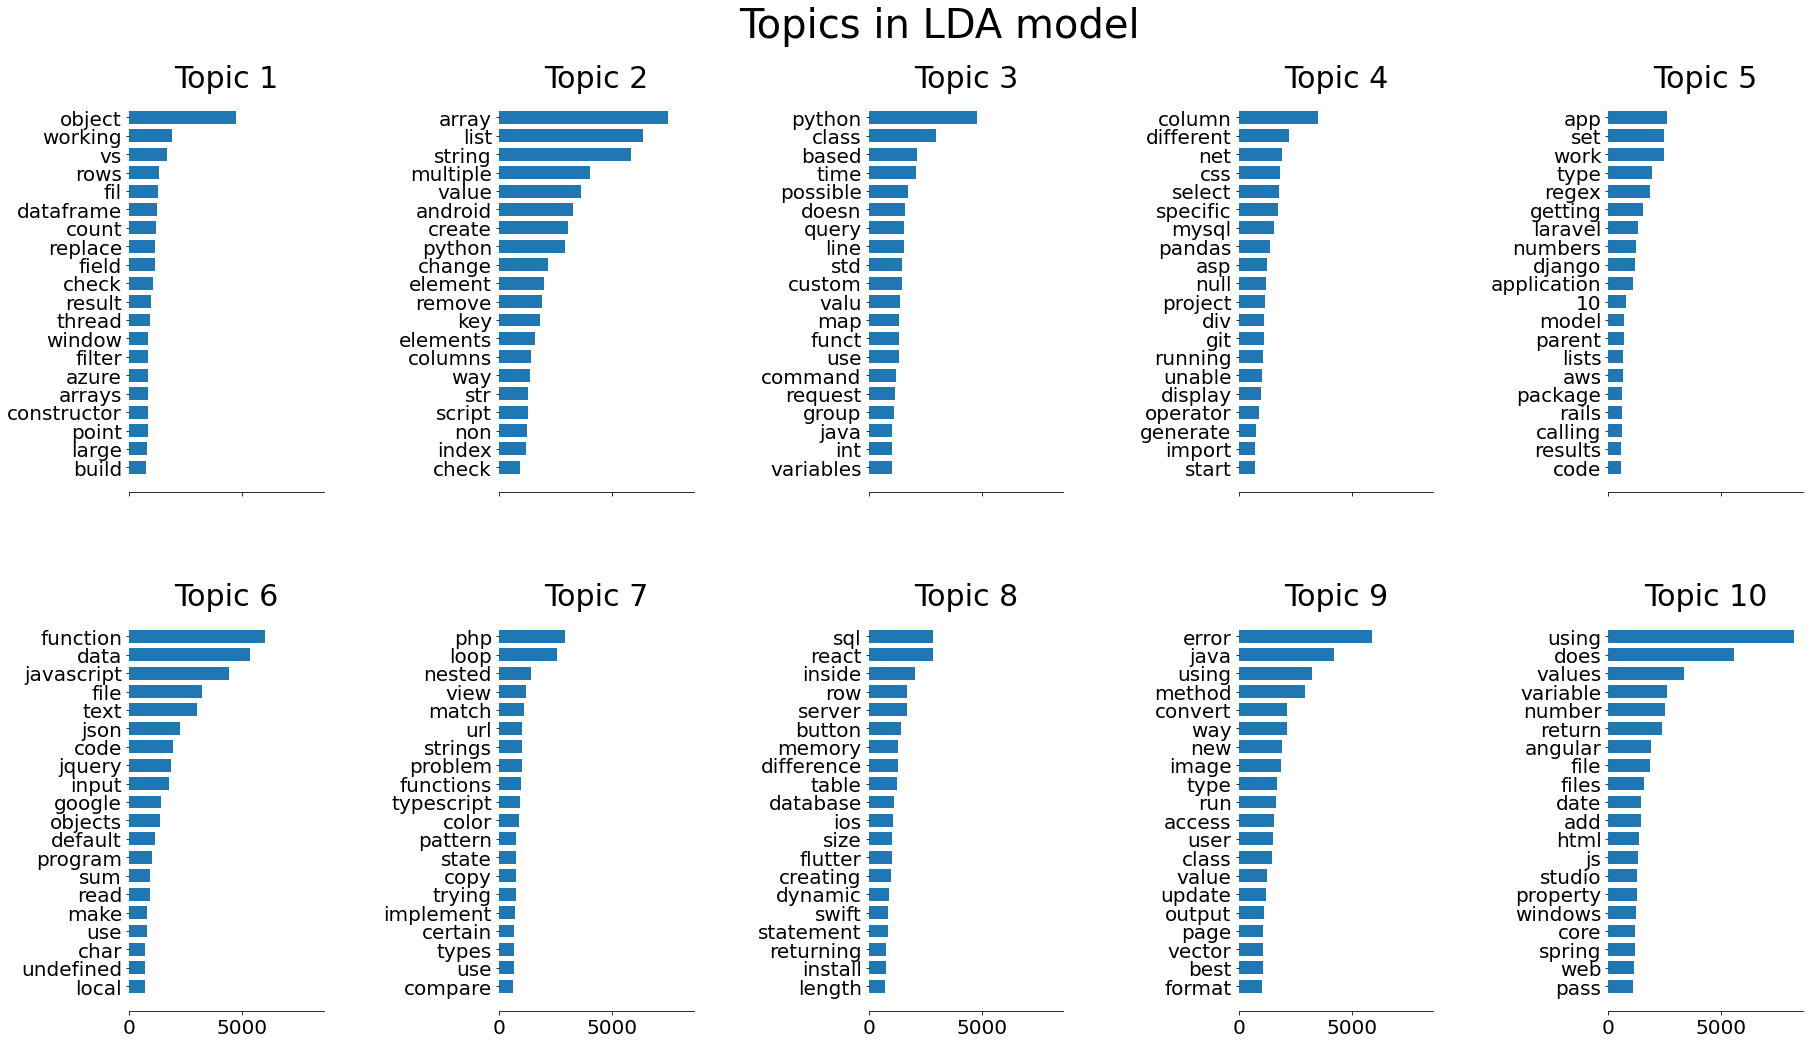

In [40]:
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=42)
lda.fit(title_tf)
tf_feature_names = tf_vectorizer.get_feature_names()
plot_top_words(lda, tf_feature_names, n_top_words, 'Topics in LDA model')

### b) Body

In [41]:
body_tfidf = tfidf_vectorizer.fit_transform(data_posts["Body"])
body_tf = tf_vectorizer.fit_transform(data_posts["Body"])

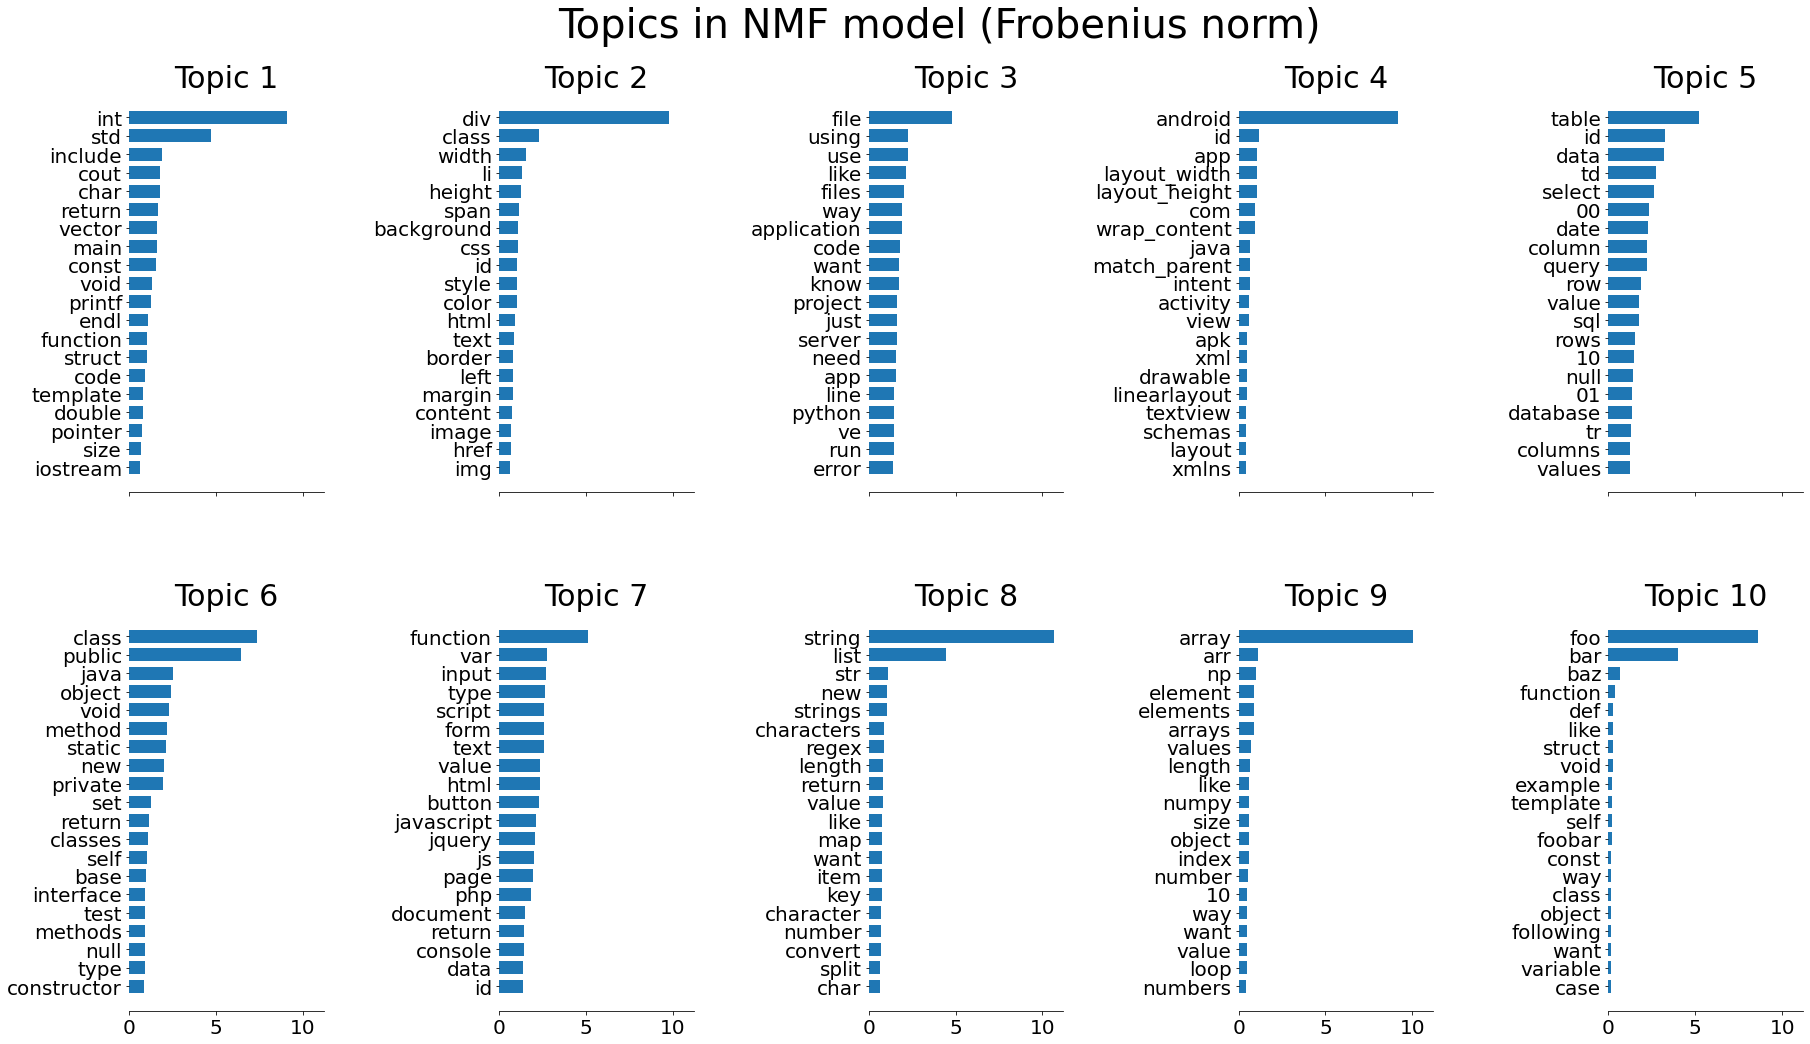

In [42]:
nmf = NMF(n_components=n_components, random_state=42,
          alpha=.1, l1_ratio=.5).fit(body_tfidf)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_top_words(nmf, tfidf_feature_names, n_top_words,
               'Topics in NMF model (Frobenius norm)')

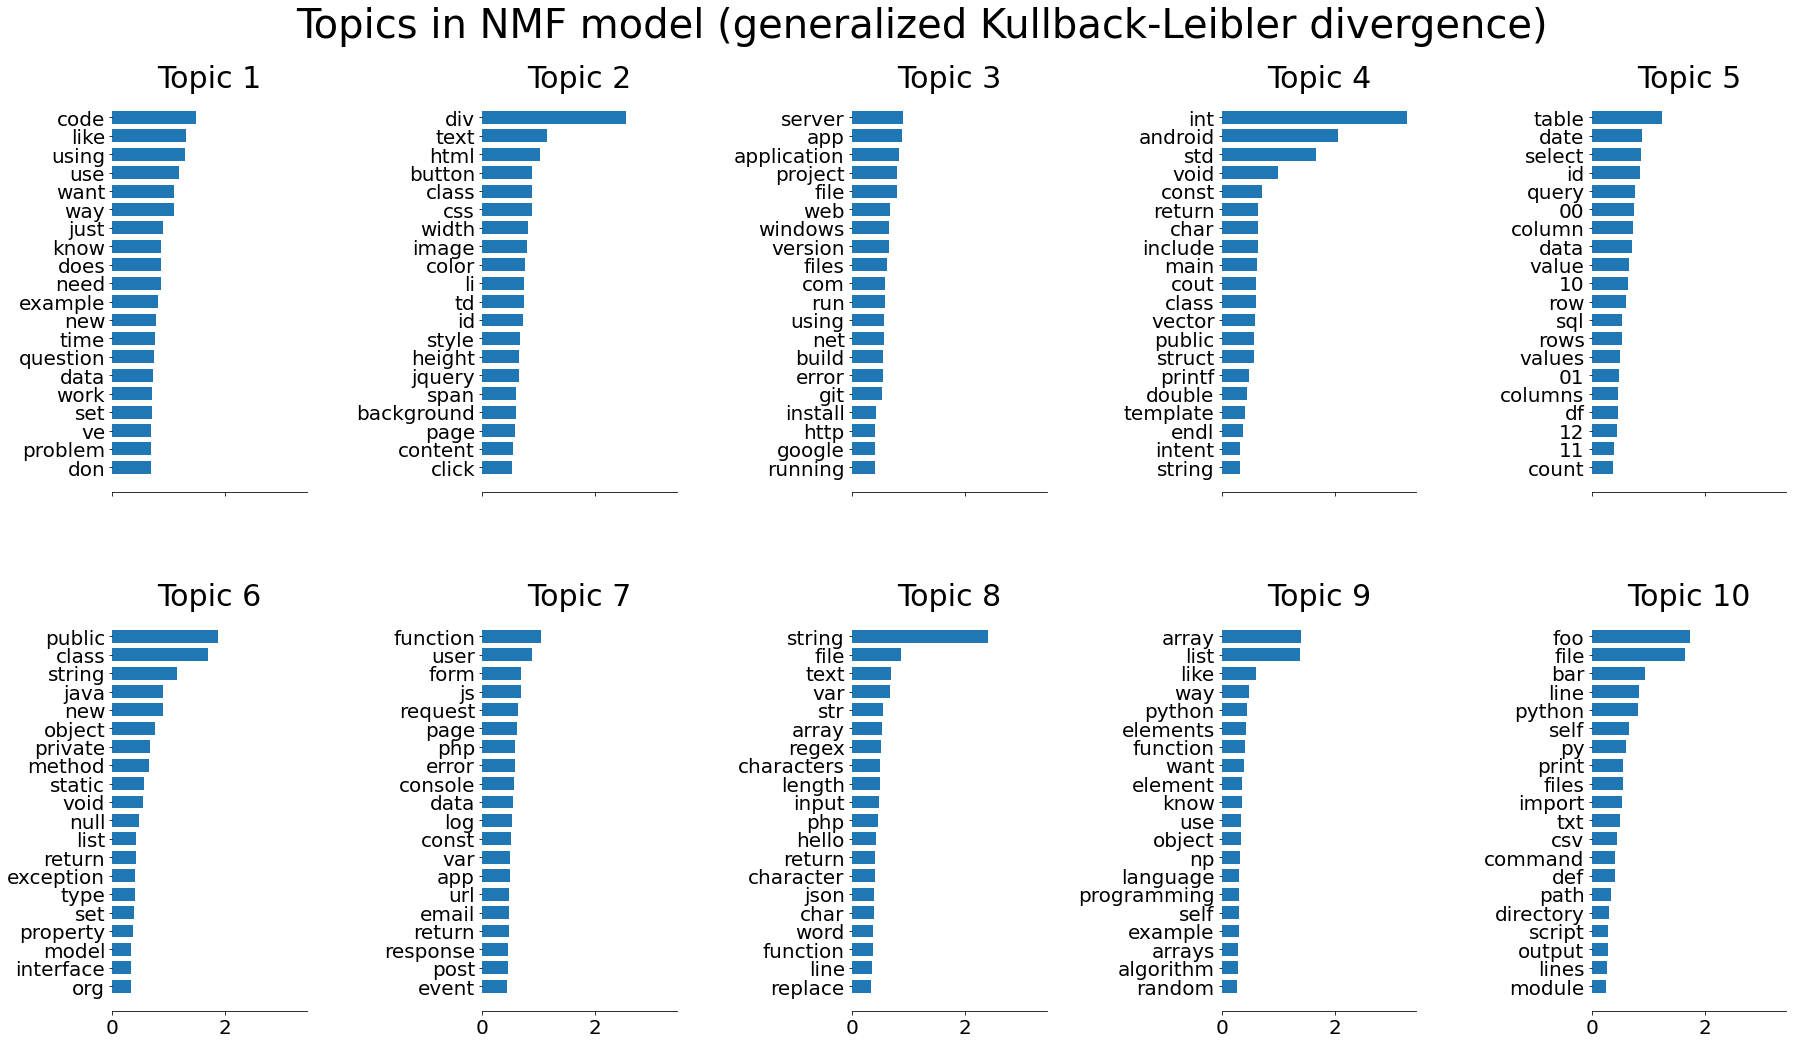

In [43]:
nmf = NMF(n_components=n_components, random_state=42,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5).fit(body_tfidf)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_top_words(nmf, tfidf_feature_names, n_top_words,
               'Topics in NMF model (generalized Kullback-Leibler divergence)')

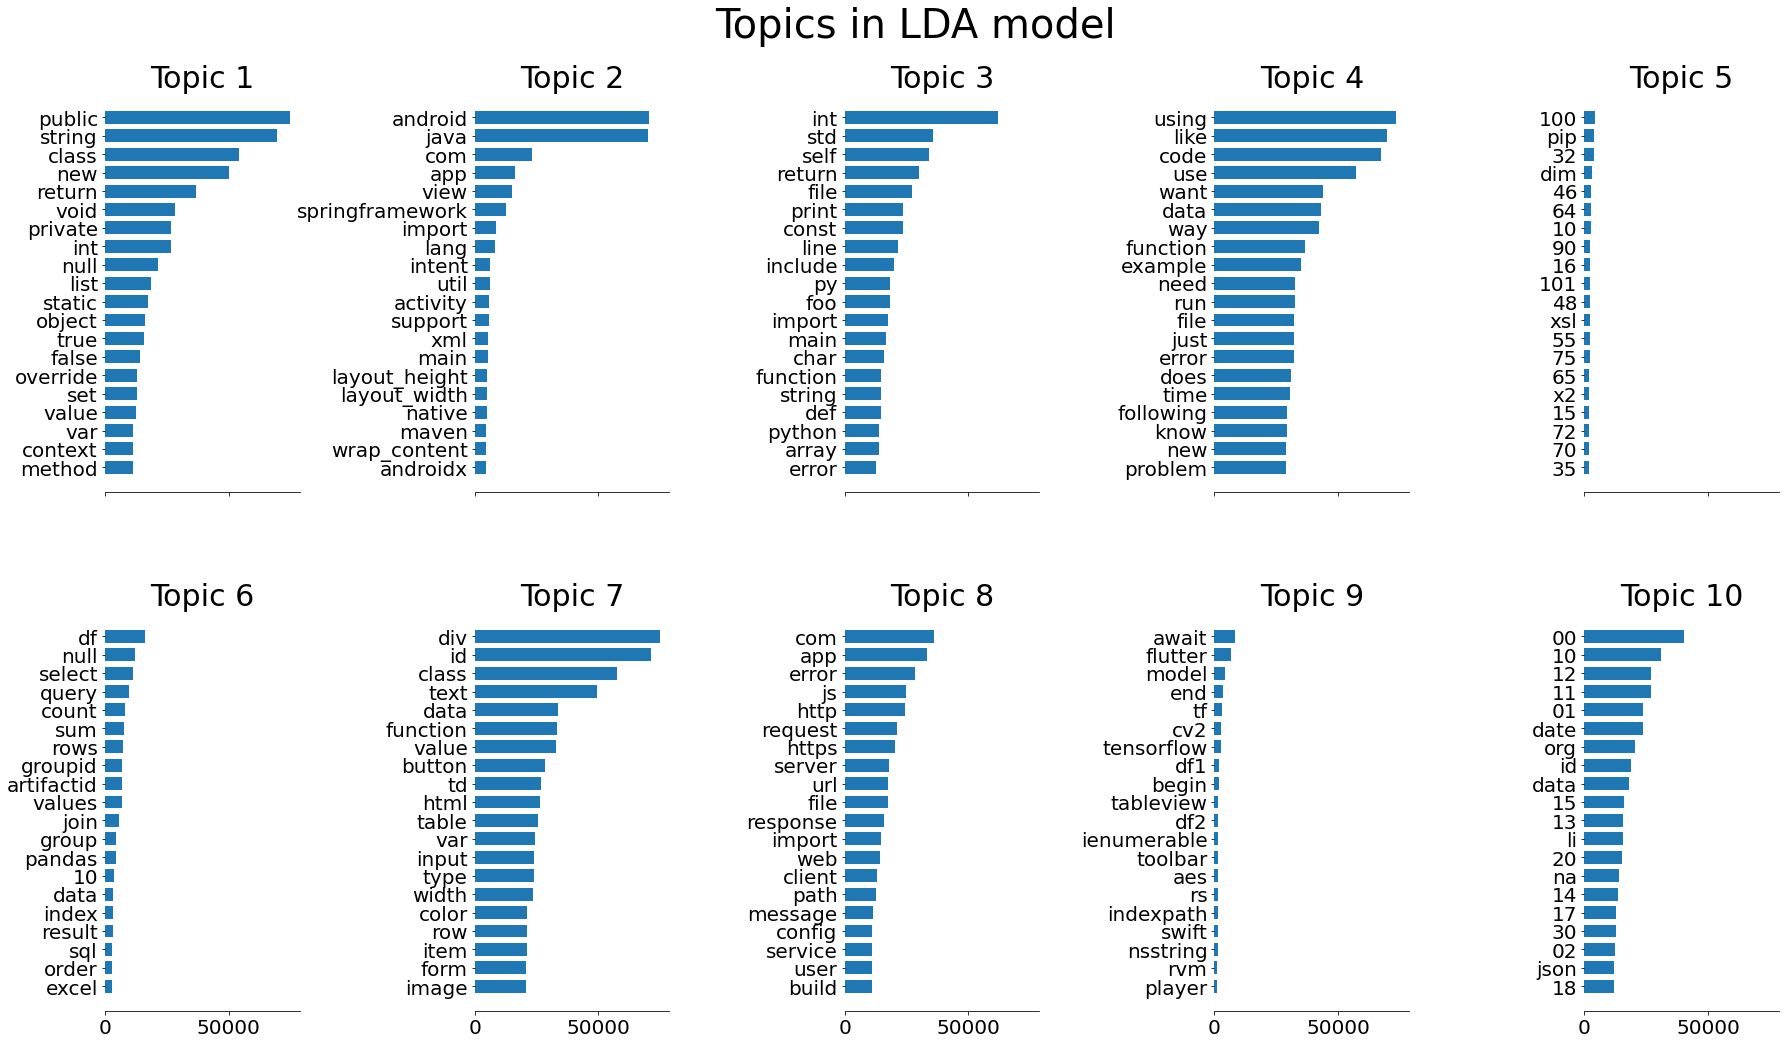

In [44]:
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=42)
lda.fit(body_tf)
tf_feature_names = tf_vectorizer.get_feature_names()
plot_top_words(lda, tf_feature_names, n_top_words, 'Topics in LDA model')